In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import os

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# set rand seed
np.random.seed(1)

In [110]:
# old, use new preprocessing

# # preprocess data

# # remove incomplete samples
# df[df=='?']=np.nan  # replace ? with nan
# n_rows = len(df)
# df=df.dropna(axis=0) # drop any rows with nan values
# n_dropped = n_rows - len(df)
# print('dropped {} rows out of {}'.format(n_dropped, n_rows))

# # set classification column to binary
# df['income'].replace({'<=50K':0,'>50K':1},inplace=True)

# df = df.drop('education.num',axis=1) # remove education num column, since redundant
# df = df.drop('fnlwgt', axis=1) # shown to have negative correlation 
# df.shape

# # encode categorical features with label encoding, not one-hot encoding
# cat_features = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
# for feature in cat_features:
#     labelencoder = LabelEncoder()
#     df[feature] = labelencoder.fit_transform(df[feature])
# df

# randomly generate train and test sets


# x_df = df.drop(['income'], axis=1)
# y_df = df['income']

# data_train, data_test, labels_train, labels_test = train_test_split(x_df.values, y_df.values, test_size=0.2, random_state=1)

In [111]:
# import dataframes
X_train = pd.read_csv('./data/X_train_adult.csv')
X_test = pd.read_csv('./data/X_test_adult.csv')
y_train = pd.read_csv('./data/y_train_adult.csv')
y_test = pd.read_csv('./data/y_test_adult.csv')

print(X_train.shape)
print(y_train.values.shape)
print(y_train.columns)

(26048, 14)
(26048, 3)
Index(['Unnamed: 0', 'id', 'income'], dtype='object')


In [112]:
# optimal boosting parameters found using optina:
parameters = {
    'reg': 0.014,
    'gamma': 0.519,
    'feature_sel': 0.7,
    'max_depth': 7,
    'min_child_weight': 2.944,
    'min_num_leaf': 13,
    'boosting_rounds': 3,
    'lr': 0.2898
}
train_num = 10000

In [113]:
%%time
boost_num = [2, 4, 6, 8, 10]
acc_boost_num = np.zeros(len(boost_num))

for idx, each in enumerate(boost_num):
    model_br = xgboost2.XGBoostClassifier()
    model_br.fit(X_train.values[:train_num,:], y_train['income'].values[:train_num],
                 reg = parameters['reg'],
                 gamma = parameters['gamma'],
                 feature_sel = parameters['feature_sel'],
                 max_depth = parameters['max_depth'],
                 min_child_weight = parameters['min_child_weight'],
                 min_num_leaf = parameters['min_num_leaf'],
                 boosting_rounds = each,
                 lr = parameters['lr'])
    pred = model_br.predict(X_test.values)
    acc_boost_num[idx] = np.sum(pred == y_test['income'].values)/len(pred)
    
print(acc_boost_num)

boosting round 0
boosting round 1
boosting round 0
boosting round 1
boosting round 2
boosting round 3
boosting round 0
boosting round 1
boosting round 2
boosting round 3
boosting round 4
boosting round 5
boosting round 0
boosting round 1
boosting round 2
boosting round 3
boosting round 4
boosting round 5
boosting round 6
boosting round 7
boosting round 0
boosting round 1
boosting round 2
boosting round 3
boosting round 4
boosting round 5
boosting round 6
boosting round 7
boosting round 8
boosting round 9
[0.80147398 0.80869031 0.80654076 0.81053278 0.81160755]
Wall time: 48min 27s


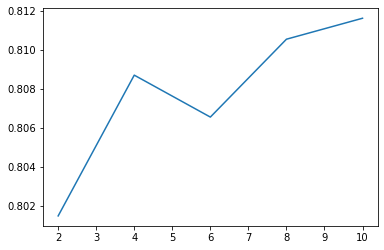

In [114]:
import matplotlib.pyplot as plt
plt.plot([2, 4, 6, 8, 10], acc_boost_num)
plt.show()

In [115]:
%%time
max_depth = [1, 5, 9, 13, 17]
acc_max_depth = np.zeros(len(max_depth))

for idx, each in enumerate(max_depth):
    model_br = xgboost2.XGBoostClassifier()
    model_br.fit(X_train.values[:train_num,:], y_train['income'].values[:train_num],
                 reg = parameters['reg'],
                 gamma = parameters['gamma'],
                 feature_sel = parameters['feature_sel'],
                 max_depth = each,
                 min_child_weight = parameters['min_child_weight'],
                 min_num_leaf = parameters['min_num_leaf'],
                 boosting_rounds = parameters['boosting_rounds'],
                 lr = parameters['lr'])
    pred = model_br.predict(X_test.values)
    acc_max_depth[idx] = np.sum(pred == y_test['income'].values)/len(pred)
    
print(acc_max_depth)

boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
[0.72639337 0.79871027 0.80869031 0.80776908 0.80792262]
Wall time: 20min 48s


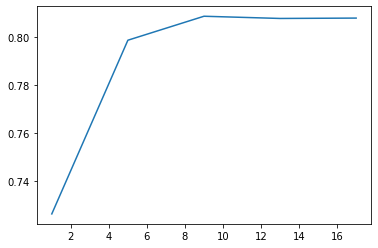

In [117]:
import matplotlib.pyplot as plt
plt.plot(max_depth, acc_max_depth)
plt.show()

In [118]:
%%time
leaf_num = [1, 5, 10, 15, 20, 25]
acc_leaf_num = np.zeros(len(leaf_num))

for idx, each in enumerate(leaf_num):
    model_lf = xgboost2.XGBoostClassifier()
    model_lf.fit(X_train.values[:train_num,:], y_train['income'].values[:train_num],
                 reg = parameters['reg'],
                 gamma = parameters['gamma'],
                 feature_sel = parameters['feature_sel'],
                 max_depth = parameters['max_depth'],
                 min_child_weight = parameters['min_child_weight'],
                 min_num_leaf = each,
                 boosting_rounds = parameters['boosting_rounds'],
                 lr = parameters['lr'])
    pred = model_lf.predict(X_test.values)
    acc_leaf_num[idx] = np.sum(pred == y_test['income'].values)/len(pred)
    
print(acc_leaf_num)

boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
[0.80807616 0.79963151 0.80531245 0.80838323 0.81222171 0.80577307]
Wall time: 26min 5s


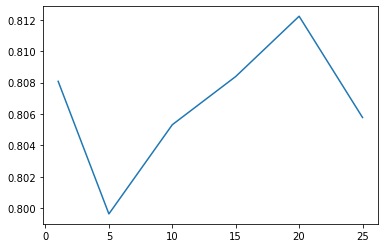

In [119]:
import matplotlib.pyplot as plt
plt.plot(leaf_num, acc_leaf_num)
plt.show()

In [120]:
%%time
min_child_weight_range = [0.1, 0.8, 1.5, 2.2, 2.9, 3.6]
acc_min_child_weight = np.zeros(len(min_child_weight_range))

for idx, each in enumerate(min_child_weight_range):
    model_mcw = xgboost2.XGBoostClassifier()
    model_mcw.fit(X_train.values[:train_num,:], y_train['income'].values[:train_num],
                 reg = parameters['reg'],
                 gamma = parameters['gamma'],
                 feature_sel = parameters['feature_sel'],
                 max_depth = parameters['max_depth'],
                 min_child_weight = each,
                 min_num_leaf = parameters['min_num_leaf'],
                 boosting_rounds = parameters['boosting_rounds'],
                 lr = parameters['lr'])
    pred = model_mcw.predict(X_test.values)
    acc_min_child_weight[idx] = np.sum(pred == y_test['income'].values)/len(pred)
    
print(acc_min_child_weight)

boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
boosting round 0
boosting round 1
boosting round 2
[0.80085982 0.7968678  0.80362352 0.80147398 0.81160755 0.79824965]
Wall time: 26min 38s


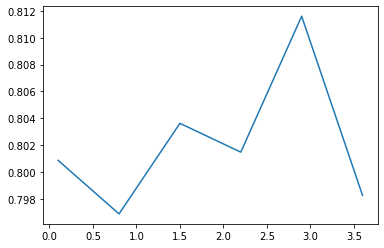

In [121]:
import matplotlib.pyplot as plt
plt.plot(min_child_weight_range, acc_min_child_weight)
plt.show()


model = xgboost2.XGBoostClassifier()
start = time.time()
model.fit(X_train.values, y_train['income'].values, min_num_leaf=5, boosting_rounds=5, max_depth=10, lr=0.8, reg=1.2)
end = time.time()
print('training time: {} min'.format((end-start)/60) )

In [93]:
pred = model.predict(X_test.values)
acc = np.sum(pred == y_test['income'].values)/len(pred)
print('accuracy = {}'.format(acc))

f1_score = sklearn.metrics.f1_score(y_test['income'].values, pred)
print('f1_score: {}'.format(f1_score))

accuracy = 0.820205742361431
f1_score: 0.6871493454448304
